# Objective:

The city of Boston performs health inspection on licensed restaurants, and published its data for 2015. The inspection result is measured with a metric referred as the violation level. Also included in the data are other identifying features such as the restaurants' names, geographic locations. The data can be matched with other restaurant features, such as Yelp rating, price range, building age, gross revenue, etc., which can be highly correlated with the violation level. We aim to build a model to predict the potential voilation levels based on these features. More specifically, the goals are:
* To perform exploratory analysis on the data, mapping out specific violation types.
* To incorporate Yelp data such as customer ratings, price range, etc., in order to model the violation levels.
* To incorporate Zillow data and add property values as a predicting feature.
* To explore Yelp comments using NLP to extract potential violation types.

# Data

The food establish inspection data is available at:

https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w

Detailed explanation of the data:

http://www.cityofboston.gov/isd/health/foodcourt.asp

# Exploratory analysis

Loading python packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from collections import Counter

Loading data:

In [2]:
InspDataRaw = pd.read_csv('Food_Establishment_Inspections.csv', low_memory=False)

In [3]:
InspDataRaw.columns

Index([u'﻿BusinessName', u'DBAName', u'LegalOwner', u'NameLast', u'NameFirst',
       u'LICENSENO', u'ISSDTTM', u'EXPDTTM', u'LICSTATUS', u'LICENSECAT',
       u'DESCRIPT', u'RESULT', u'RESULTDTTM', u'Violation', u'ViolLevel',
       u'ViolDesc', u'VIOLDTTM', u'ViolStatus', u'StatusDate', u'Comments',
       u'Address', u'City', u'State', u'Zip', u'Property_ID', u'Location'],
      dtype='object')

In [18]:
#InspDataRaw.Violation.head()

0            NaN
1    21-3-304.14
2    23-4-602.13
3    21-3-304.14
4    15-4-202.16
Name: Violation, dtype: object

# Types and levels of violation

We first examine the types violations, labeled as "Violation". Repeated violations might have happened for the same BusinessName, but for this step, we do not combine results for the same business.

In [4]:
#InspDataRaw.head()
VioTypes = InspDataRaw.Violation.astype('S32')
#VioTypes.head(9)

The violation types are categorized by the first digit/letter in the violation code, according to the description:

http://www.cityofboston.gov/isd/health/violationcodes.asp


In [5]:
def merge_dicts(*dict_args): # merging dictinary together, used later
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

foodProt = {'Food Protection Management':['M']} # Food Protection Management
food = {'Food':[str(x) for x in range(1,3)]} # Food
timeTemp = {'Food Protection, Time & Temperature Controls':[str(x) for x in range(3,7)]} # Food Protection, Time & Temperature Controls
contam = {'Food Protection From Contamination':[str(x) for x in range(7,11)]} # Food Protection From Contamination
pers = {'Personnel':[str(x) for x in range(11,14)]} # Personnel
eq = {'Equipment and Utensils':[str(x) for x in range(14,27)]} # Equipment and Utensils
wat = {'Water':['27']} # water
sew = {'Sewage':['28']} # sewage
plumb = {'Plumbing':['29','30']} # plumbing
wc = {'Toilet and Handwashing Facilities':['31','32']} # Toilet and Handwashing Facilities
disp = {'Refuse Disposal':['33','34']} # Refuse Disposal
anim = {'Insect, Rodent, Animal Control':['35']} # Insect, Rodent, Animal Control
physFac = {'Physical Facilities':[str(x) for x in range(37,41)]} # Physical Facilities
othOp = {'Other Operations':[str(x) for x in range(41,45)]} # Other Operations
highPop = {'Highly Susceptible Populations':['45']} # Highly Susceptible Populations

VioDict = merge_dicts(foodProt,food,timeTemp,contam,pers,eq,wat,sew,plumb,wc,disp,anim,physFac,othOp,highPop)



Showing histogram of violation types:

Counter({'Equipment and Utensils': 118041, 'Physical Facilities': 38231, 'Toilet and Handwashing Facilities': 23347, 'Other Operations': 19174, 'Food Protection Management': 14555, 'Plumbing': 11271, 'Personnel': 8481, 'Insect, Rodent, Animal Control': 8078, 'Refuse Disposal': 8067, 'Food Protection From Contamination': 4503, 'Water': 1465, 'Sewage': 153, 'Highly Susceptible Populations': 7})


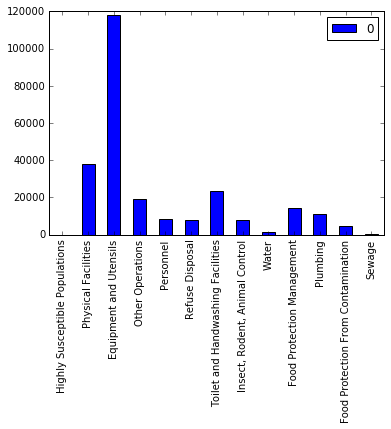

In [6]:
VioTypes = VioTypes.apply(lambda x: x.split('-')[0]) # the first digit used to match code dict
VioValues = []
for vioValue in VioDict.values(): 
    VioValues += vioValue
# print VioValues
VioTypes_clean = [x for x in VioTypes if x in VioValues]

def categ_vioTypes(vioType, VioDict): # merging dictinary together, used later
    '''
    Given a string of vioType, categorize it according to the VioDict dictionary
    '''
    VioKeys = VioDict.keys()
    VioValues = VioDict.values()
    for i in range(len(VioValues)):
        if vioType in VioValues[i]:
            vioCode = VioKeys[i]
    return vioCode
#VioTypes_clean

VioTypes_categ = []
for vioType in VioTypes_clean:
    VioTypes_categ.append(categ_vioTypes(vioType, VioDict))
VioTypes_count= Counter(VioTypes_categ)
print VioTypes_count
VioTypes_hist = pd.DataFrame.from_dict(VioTypes_count, orient='index')
print VioTypes_hist
VioTypes_hist.plot(kind='bar')

Now we examine the levels of violation

In [7]:
VioLevels = InspDataRaw.ViolLevel.astype('S32')
#VioLevels_clean = [x for x in VioLevels if x != 'nan']
#print VioLevels_clean

Counter({1: 251386, 3: 58318, 2: 20932, 4: 1})
        0
1  251386
2   20932
3   58318
4       1


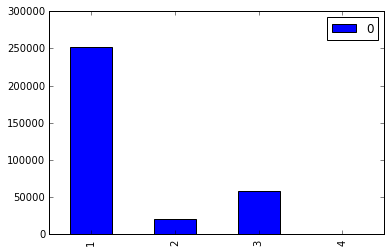

In [16]:
VioLevels_clean = [x for x in VioLevels if x != 'nan']
VioLevels_num = []
for vioLevel in VioLevels_clean:
    VioLevels_num.append(len(vioLevel))
VioLevels_count = Counter(VioLevels_num)
print VioLevels_count
VioLevels_hist = pd.DataFrame.from_dict(VioLevels_count, orient='index')
print VioLevels_hist
VioLevels_hist.plot(kind='bar')

In [ ]:
c